# Heart Failure Classification 

This assignment generates an ensemble of primitive classifiers and compares performance to the regular classifiers.

**Problem**: Heart failure classification using Kaggle's `heart.csv` dataset. Download the dataset from the Datasets directory. 

In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from copy import deepcopy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from typing import Callable, List, Tuple, Any, Dict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
import random

## Data Exploration and Preprocessing

In [2]:
heart_data = pd.read_csv('Datasets/heart_dataset.csv')

In [3]:
heart_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Kaggle provided the following descriptions for the features:
- **Age:** patient's age
- **Sex:** patient's gender
- **ChestPainType:** chest pain type:
    - TA: Typical Angina
    - ATA: Atypical Angina
    - NAP: Non-Anginal Pain
    - ASY: Asymptomatic
- **RestingBP:** resting blood pressure [mm Hg]
- **Cholesterol:** serum cholesterol [mm/dl]
- **FastingBS:** fasting blood sugar [1: if > 120 mg/dl, 0: otherwise]
- **RestingECG:** resting electrocardiogram results
    - Normal: Normal
    - ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria
- **MaxHR:** maximum heart rate achieved [range 60-202]
- **ExerciseAngina:** exercise-induced angina [Yes or No]
- **Oldpeak:** oldpeak = ST [numeric value measured in depression]
- **ST_Slope:** the slop of the peak exercise ST segment
    - Up: upsloping
    - Flat: flat
    - Down: downsloping
- **HeartDisease:** dependent variable [1: heart disease, 0: normal]


**Additional Terminology Notes**: 
- **angina:** a condition marked by severe pain in the chest, often spreading to the shoulders, arms, and neck, caused by an inadequate blood supply to the heart.
- **ST:** the ST segment represents the period in which the myocardium maintains contraction to expel blood from the ventricles (Kashou, Basit, & Malik, 2023).
- **oldpeak:** ST depression induced by exercise (Latha & Jeeva, 2019). 

In [4]:
(rows, cols) = heart_data.shape
print(f"There are {rows} examples in the heart dataset")
print(f"There are {cols} features in the heart dataset")

There are 918 examples in the heart dataset
There are 12 features in the heart dataset


In [5]:
# check for duplicate entries
print(f"Duplicated Entries: {len([1 for entry in heart_data.duplicated() if entry == True])}")

Duplicated Entries: 0


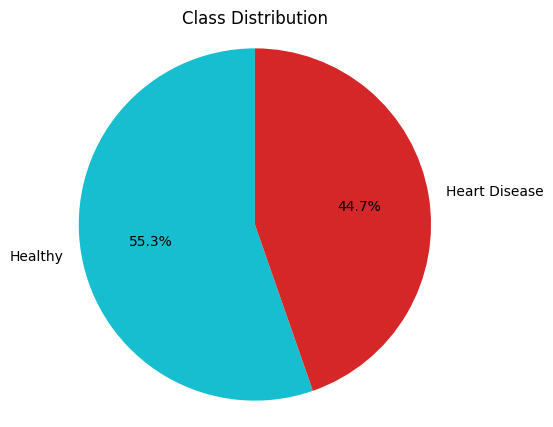

In [6]:
# plot the class distribution
fig = plt.figure(figsize=(5, 5))
labels = 'Healthy', 'Heart Disease'
hd_dist = [len(heart_data[heart_data['HeartDisease'] == 1]), len(heart_data[heart_data['HeartDisease'] == 0])] 

plt.pie(hd_dist, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#17becf', '#d62728'])
plt.axis('equal')  
plt.title('Class Distribution')
plt.show()

The dataset has a relatively even class distribution. Therefore, k-fold validation will be a good evaluation technique. Accuracy could work for this dataset. However, this problem should favor a high recall and penalize false negative predictions more than false positives. The evaluation metrics used will be the F1 score and Recall.  

In [7]:
# check for null values
print(f"Missing values in the training set:\n{heart_data.isnull().sum()}")

Missing values in the training set:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [8]:
# examine data types
print(heart_data.dtypes)

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


In [9]:
# one hot encode the nominal variables
heart_df = pd.get_dummies(heart_data, columns = ['ChestPainType', 'RestingECG', 'ST_Slope', 'Sex'])

# convert boolean values to 0 and 1 instead of T and F
heart_df['ExerciseAngina'] = [1 if entry == 'Y' else 0 for entry in heart_df['ExerciseAngina']]

In [10]:
# convert ints to floats
heart_df = heart_df.astype(float)

# examine data types
print(heart_df.dtypes)

Age                  float64
RestingBP            float64
Cholesterol          float64
FastingBS            float64
MaxHR                float64
ExerciseAngina       float64
Oldpeak              float64
HeartDisease         float64
ChestPainType_ASY    float64
ChestPainType_ATA    float64
ChestPainType_NAP    float64
ChestPainType_TA     float64
RestingECG_LVH       float64
RestingECG_Normal    float64
RestingECG_ST        float64
ST_Slope_Down        float64
ST_Slope_Flat        float64
ST_Slope_Up          float64
Sex_F                float64
Sex_M                float64
dtype: object


In [11]:
heart_df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,Sex_F,Sex_M
0,40.0,140.0,289.0,0.0,172.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,49.0,160.0,180.0,0.0,156.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,37.0,130.0,283.0,0.0,98.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,48.0,138.0,214.0,0.0,108.0,1.0,1.5,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,54.0,150.0,195.0,0.0,122.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


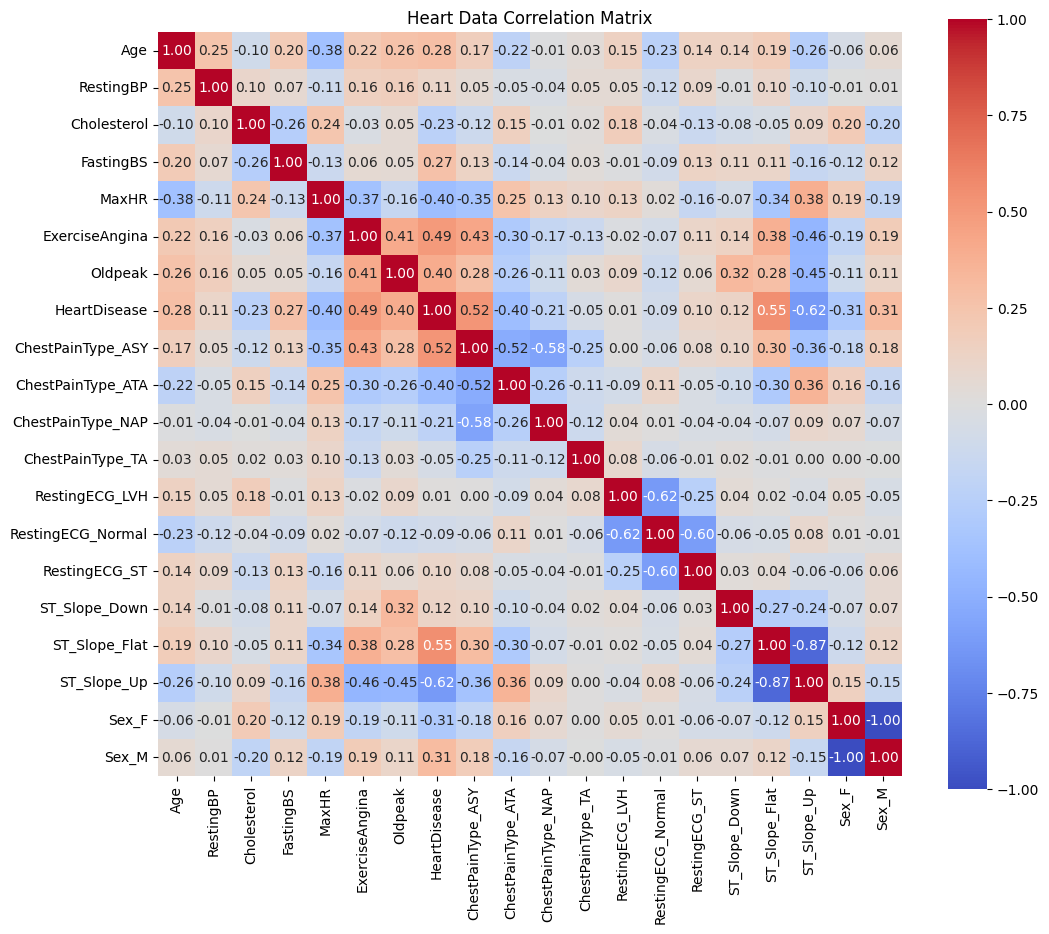

In [12]:
import matplotlib.pyplot as plt
from copy import deepcopy

# get correlation matrix
corr = heart_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)

# add title
plt.title('Heart Data Correlation Matrix')
plt.show()

The correlation matrix above shows that the RestingECG and RestingBP features have the lowest correlation to the dependent variable. All other features demonstrate correlations to the dependent variables. The ensemble tests below will use all features as outlined in the instructions. 

### Test a Baseline Classifier: Logistic Regression

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, classification_report

# split train and test
heart_data = heart_df.drop('HeartDisease', axis=1)
labels = heart_df['HeartDisease']

# standardize the data
scaler = StandardScaler()
heart_data = scaler.fit_transform(heart_data)

# the training dataset will be used for ensemble training and validation. The test set will be held out for final evaluation. 
x_train, x_test, y_train, y_test = train_test_split(heart_data, labels, test_size=0.1, random_state=42)

# logistic regression model
lr_model = LogisticRegression(random_state=42)

lr_model.fit(x_train, y_train)

# predictions
y_pred = lr_model.predict(x_test)

# evaluate the model
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.84      0.84        38
         1.0       0.89      0.89      0.89        54

    accuracy                           0.87        92
   macro avg       0.87      0.87      0.87        92
weighted avg       0.87      0.87      0.87        92



The baseline classifier reached an F1 score and recall score of 87%. The ensemble methods below aim to improve this performance.  

### Helper Functions

<a id="k_fold"></a>
### k_fold

*The k_fold function runs k_fold validation using the provided model function or pipeline. The function outputs the average recall and F1 scores (with standard deviation) for the training and test sets.*

* **data** np.array: a dataset 
* **labels** List[str]: a list of feature names for the dataframe columns and rows
* **n_folds** int: the number of folds
* **pipeline** Callable: a callable model or pipeline

**returns** None

In [14]:
def k_fold(data: np.array, labels: List[str], n_folds: int, pipeline: Callable) -> None:
    train_f1s, train_recs, test_f1s, test_recs = [], [], [], []
    k_fold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    for train_idx, test_idx in k_fold.split(data, labels):
        train_data, train_labels = data[train_idx], labels[train_idx]
        test_data, test_labels = data[test_idx], labels[test_idx]

        # train model
        pipeline.fit(train_data, train_labels)

        # make predictions
        train_predictions = pipeline.predict(train_data)
        test_predictions = pipeline.predict(test_data)

        # get evaluation metrics
        train_rec = round(100 * recall_score(train_labels, train_predictions), 2)
        test_rec = round(100 * recall_score(test_labels, test_predictions), 2)
        train_f1 = round(100 * f1_score(train_labels, train_predictions), 2)
        test_f1 = round(100 * f1_score(test_labels, test_predictions), 2)

        # append accuracies and f1 scores to results
        train_f1s.append(train_f1)
        test_f1s.append(test_f1)
        train_recs.append(train_rec)
        test_recs.append(test_rec)

    print(f'10-fold CV Train Recall: {np.mean(train_recs):.3f} {chr(177)}{np.std(train_recs):.4f}, Train F1 Score: {np.mean(train_f1s):.3f} {chr(177)}{np.std(train_f1s):.4f}')
    print(f'10-fold CV Test Recall: {np.mean(test_recs):.3f} {chr(177)}{np.std(test_recs):.4f}, Test F1 Score: {np.mean(test_f1s):.3f} {chr(177)}{np.std(test_f1s):.4f}')
    print("\n")

<a id="get_balanced_subsample"></a>
### get_balanced_subsample

*The get_balanced_subsample function draws a random number of samples with an even class distribution.* **used_by** [ensemble_fit](#ensemble_fit)

* **num_samples** int: the number of datapoints for the entire subsample 
* **x_train** np.array: the training data
* **y_train** np.array: the training labels

**returns** Tuple[np.array]

In [15]:
def get_balanced_subsample(num_samples: int, x_train: np.array, y_train: np.array) -> Tuple[np.array]:
    
    class_0 = [i for i, label in enumerate(y_train) if label == 0]
    class_1 = [i for i, label in enumerate(y_train) if label == 1]
    
    n_class_0 = num_samples//2
    n_class_1 = num_samples - n_class_0
    
    class_0_sample = random.sample(class_0, n_class_0)
    class_1_sample = random.sample(class_1, n_class_1)
    
    subsample_indices = class_0_sample + class_1_sample
    
    return x_train[subsample_indices], y_train[subsample_indices]

<a id="print_output"></a>
### print_output

*The print_output function displays the f1 score and recall score for the training and test sets used for k-fold validation.* **used_by** [k_fold_ensemble](#k_fold_ensemble)

* **train_f1s** list[float]: the training f1 scores for each fold
* **train_recs** List[float]: the training recalls for each fold
* **test_f1s** List[float]: the test f1 scores for each fold
* **test_recs** List[float]: the test recall scores for each fold

**returns** None

In [16]:
def print_output(train_f1s: List[float], train_recs: List[float], test_f1s: List[float], test_recs: List[float]) -> None:
    print(f'Train Recall: {np.mean(train_recs):.3f} {chr(177)}{np.std(train_recs):.4f}, Train F1 Score: {np.mean(train_f1s):.3f} {chr(177)}{np.std(train_f1s):.4f}')
    print(f'Test Recall: {np.mean(test_recs):.3f} {chr(177)}{np.std(test_recs):.4f}, Test F1 Score: {np.mean(test_f1s):.3f} {chr(177)}{np.std(test_f1s):.4f}')
    print('\n')

### Report 10-fold CV performances of GaussianNB, linear SVC, MLPClassifier, and DecisionTreeClassifier with default parameters. Then, report the RandomForestClassifier performance.

### 10-fold GaussianNB Classifier

In [17]:
# convert to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# run 10-fold validation with Niave Bayes Classifier
nb_model = GaussianNB()
k_fold(x_train, y_train, 10, nb_model)

10-fold CV Train Recall: 87.934 ±0.4948, Train F1 Score: 87.550 ±0.5262
10-fold CV Test Recall: 87.626 ±3.9390, Test F1 Score: 87.221 ±3.9999




### 10-fold Linear Support Vector Machine

In [18]:
# run 10-fold validation with svm linear kernel
svm_model = svm.SVC(kernel="linear", probability=True, random_state=42)
k_fold(x_train, y_train, 10, svm_model)

10-fold CV Train Recall: 90.430 ±0.6589, Train F1 Score: 88.874 ±0.5197
10-fold CV Test Recall: 89.422 ±5.1330, Test F1 Score: 87.971 ±4.4529




### 10-fold Multilayer Perceptron

In [19]:
# suppress failed to converge warning when running MLP with default params
warnings.filterwarnings('ignore', category=ConvergenceWarning)
# run 10-fold validation with mlp
mlp_model = MLPClassifier(random_state=42)
k_fold(x_train, y_train, 10, mlp_model)

10-fold CV Train Recall: 95.520 ±0.4539, Train F1 Score: 94.331 ±0.4554
10-fold CV Test Recall: 88.829 ±4.6468, Test F1 Score: 87.563 ±4.0571




### 10-fold Decision Tree Classsifier

In [20]:
# run 10-fold validation with decision tree
dt_model = DecisionTreeClassifier(random_state=42)
k_fold(x_train, y_train, 10, dt_model)

10-fold CV Train Recall: 100.000 ±0.0000, Train F1 Score: 100.000 ±0.0000
10-fold CV Test Recall: 80.990 ±4.7563, Test F1 Score: 80.909 ±2.3312




### 10-fold Random Forest Classifier

In [21]:
# Run 10-fold validation and a random forest
rf_model = RandomForestClassifier(random_state=42)
k_fold(x_train, y_train, 10, rf_model)

10-fold CV Train Recall: 100.000 ±0.0000, Train F1 Score: 100.000 ±0.0000
10-fold CV Test Recall: 90.463 ±3.8139, Test F1 Score: 88.996 ±3.8982




The naive bayes classifier had the best performance of the non-ensemble models with an F1 score around 87% and a standard deviation of 3.9999. The random forest obtained slightly better test performance with an F1 score around 89% and a standard deviation of 3.8982. However, the training evaluation metrics for the random forest are much higher than the test metrics. These results indicate that the random forest model is overfitting. In contrast, the naive bayes model has a comparable training and test F1 score. The random forest model reached a higher recall of around 90%. Therefore, reducing overfitting with the random forest model by tuning hyperparameters could make it the preferred choice for this problem. 

### Generate an ensemble of 100 weak classifiers for each of the four classifiers and test the first model in the ensembles.

In [22]:
# generate ensembles
nb_ensemble = [GaussianNB() for _ in range(100)]
svm_ensemble = [svm.SVC(kernel="linear", probability=True) for _ in range(100)]
dt_ensemble = [DecisionTreeClassifier(max_depth=5, max_features=5) for _ in range(100)]
mlp_ensemble = [MLPClassifier(hidden_layer_sizes=(3,3), max_iter=30, tol=1e-1) for _ in range(100)]

### Gaussian Naive Bayes Ensemble Model 1 Performance

In [23]:
nb_model_1 = nb_ensemble[0]
k_fold(x_train, y_train, 10, nb_model_1)

10-fold CV Train Recall: 87.934 ±0.4948, Train F1 Score: 87.550 ±0.5262
10-fold CV Test Recall: 87.626 ±3.9390, Test F1 Score: 87.221 ±3.9999




### Support Vector Machine Ensemble Model 1 Performance

In [24]:
svm_model_1 = svm_ensemble[0]
k_fold(x_train, y_train, 10, svm_model_1)

10-fold CV Train Recall: 90.430 ±0.6589, Train F1 Score: 88.874 ±0.5197
10-fold CV Test Recall: 89.422 ±5.1330, Test F1 Score: 87.971 ±4.4529




### Multilayer Perceptron Ensemble Model 1 Performance

In [25]:
mlp_model_1 = mlp_ensemble[0]
k_fold(x_train, y_train, 10, mlp_model_1)

10-fold CV Train Recall: 34.510 ±34.6501, Train F1 Score: 32.542 ±30.0646
10-fold CV Test Recall: 33.853 ±34.8556, Test F1 Score: 31.671 ±30.9084




### Decision Tree Ensemble Model 1 Performance

In [26]:
dt_model_1 = dt_ensemble[0]
k_fold(x_train, y_train, 10, dt_model_1)

10-fold CV Train Recall: 90.533 ±2.0839, Train F1 Score: 89.010 ±0.4482
10-fold CV Test Recall: 86.596 ±4.2236, Test F1 Score: 84.437 ±4.6171




The cells above show the results for the first model in each ensemble. Note that there was a reduction in overfitting for the decision tree model when using a "weak" classifier with a depth of 5 and max features of 5. The weak decision tree model performed better than the initial model using the default parameters above. The "weak" multilayer perceptron had much lower performance because the hyperparameter settings prevented the model from converging. The multilayer perceptron is also very sensitive to the random weight initializations and exhibits high variation between runs without a random seed value. The multilayer perceptron model using the default parameters was slightly overfitting, as shown in the cells above. The weak multilayer perceptron model is not overfitting. However, these hyperparameters have increased model bias.

### Ensemble Helper Functions

<a id="ensemble_fit"></a>
### ensemble_fit

*The ensemble_fit function takes a list of instantiated ensemble classifiers and returns a list of trained ensemble classifiers. This function trains each classifier on a random subset of the training data, using the sample_ratio parameter to determine the sample size. The [get_balanced_subsample](#get_balanced_subsample) helper function ensures that there is an even class distribution in the subsample.* **used_by** [k_fold_ensemble](#k_fold_ensemble)

* **x_train** np.array: the training data
* **y_train** np.array: the training labels
* **ensemble** List[Callable]: a list of instantiated classifiers
* **sample_ratio** float: the subsample ratio

**returns** List[Callable]

In [27]:
def ensemble_fit(x_train: np.array, y_train: np.array, ensemble: List[Callable], sample_ratio: float) -> List[Callable]:
    trained_ensemble = []
    # calculate the number of samples and floor to an int
    num_samples = int(len(x_train) * sample_ratio)
        
    for model in ensemble: 
        # get a balanced subsample
        x_sample, y_sample = get_balanced_subsample(num_samples, x_train, y_train)
        
        # fit the model and append to the ensemble
        trained_ensemble.append(model.fit(x_sample, y_sample))
    return trained_ensemble    

<a id="ensemble_predict"></a>
### ensemble_predict

*The ensemble_predict function takes an ensemble of trained classifiers and returns a prediction for each observation using majority voting. The function leverages list comprehension to generate a list of predictions for each classifier, where each row contains the predictions from a single classifier. Transposing this output makes it so each row contains n predictions for a single data point where n is the number of classifiers in the ensemble. The np.bincount() function returns the count of 0s and 1s for every row, and the np.argmax() function selects the index with the highest count (0 or 1) to make the final prediction. The function returns a list of predictions for each data point.* **used_by** [k_fold_ensemble](#k_fold_ensemble)

* **x_test** np.array: the validation data
* **ensemble** List[Callable]: a list of instantiated classifiers

**returns** List[int]

In [28]:
def ensemble_predict(x_test: np.array, ensemble: List[Callable]) -> List[int]:
    """
    Get predictions from all models and transpose so each row represents 
    model predictions for a single datapoint.
    """
    ensemble_predictions = np.array([c.predict(x_test).astype(int) for c in ensemble]).T
    
    """
    Find the majority vote for each data point by taking a count of 0s and 1s
    for each datapoint using bincount() and applying argmax() to return the prediction
    with the highest count.
    """
    majority_vote_preds = [np.argmax(np.bincount(row)) for row in ensemble_predictions]

    return majority_vote_preds

<a id="ensemble_predict_proba"></a>
### ensemble_predict_proba

*The ensemble_predict_proba function takes an ensemble of trained classifiers and returns a prediction for each observation by summing the predicted probabilities for every classifier and selecting the label with the highest summed probability. The function leverages list comprehension to generate a list of predicted probabilities for each classifier, where each row contains the predictions from a single classifier, and each column contains a tuple of predicted probabilities for a single data point. Next, the function flattens the data (rows) by summing the predicted probabilities of every classifier for a single data point. The column-wise argmax() operator returns a list of predictions for every data point.* **used_by** [k_fold_ensemble](#k_fold_ensemble)

* **x_test** np.array: the validation data
* **ensemble** List[Callable]: a list of instantiated classifiers

**returns** List[int]

In [29]:
def ensemble_predict_proba(x_test: np.array, ensemble: List[Callable]) -> List[int]:
    """
    Get predictions probabilities. 
    This will produce an array of size (n_estimators, n_examples, n_classes)
    """
    ensemble_predictions = np.array([c.predict_proba(x_test) for c in ensemble])
    
    """
    Sum the probabilities element-wise from each model for every data point.
    This will produce an array of shape (n_examples, n_classes)
    """
    summed_ensemble_preds = np.sum(ensemble_predictions, axis=0)
    
    # get the prediction for every data point with argmax
    majority_vote_preds = np.argmax(summed_ensemble_preds, axis=1)
    
    return majority_vote_preds

<a id="k_fold_ensemble"></a>
### k_fold_ensemble

*The k_fold_ensemble function uses the custom [ensemble_fit](#ensemble_fit) and [ensemble_predict](#ensemble_predict) functions to run k-fold validation for an ensemble of classifiers. The function returns the average and standard deviation of the test f1 scores to use for plotting. The function has an optional display parameter that causes it to print the training and testing f1 scores and recall. Additionally, the with_proba parameter causes the function to print the output for both c.predict() and c.predict_proba() for a comparison of these evaluation techniques.*

* **data** np.array: the dataset to use for k-fold validation
* **labels** np.array: the dataset labels
* **n_folds** int: the number of folds
* **ensemble** List[Callable]: a list of instantiated classifiers
* **sample_ratio** float: the subsample ratio to use for training
* **display** bool (default True): specifies whether to print the results
* **with_proba** bool (default False): specifies whether to print the results of both predict() and predict_proba() for comparison

**returns** Tuple[float]

In [30]:
def k_fold_ensemble(data: np.array, labels: np.array, n_folds: int, ensemble: List[Callable], sample_ratio: float, display:bool=True, with_proba:bool=True) -> Tuple[float]:
    train_f1s, train_recs, test_f1s, test_recs = [], [], [], []
    train_prob_f1s, train_prob_recs, test_prob_f1s, test_prob_recs = [], [], [], []
    k_fold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    for train_idx, test_idx in k_fold.split(data, labels):
        train_data, train_labels = data[train_idx], labels[train_idx]
        test_data, test_labels = data[test_idx], labels[test_idx]

        # train model
        trained_ensemble = ensemble_fit(train_data, train_labels, ensemble, sample_ratio)

        # make predictions with c.predict()
        train_predictions = ensemble_predict(train_data, trained_ensemble)
        test_predictions = ensemble_predict(test_data, trained_ensemble)
        
        # append accuracies and f1 scores to results for predict
        train_f1s.append(round(100 * f1_score(train_labels, train_predictions), 2))
        test_f1s.append(round(100 * f1_score(test_labels, test_predictions), 2))
        train_recs.append(round(100 * recall_score(train_labels, train_predictions), 2))
        test_recs.append(round(100 * recall_score(test_labels, test_predictions), 2))
        
        if with_proba == True:
            # make predictions with c.predict_proba()
            train_prob_preds = ensemble_predict_proba(train_data, trained_ensemble)
            test_prob_preds = ensemble_predict_proba(test_data, trained_ensemble)
            
            # append accuracies and f1 scores to results for predict_proba
            train_prob_f1s.append(round(100 * f1_score(train_labels, train_prob_preds), 2))
            test_prob_f1s.append(round(100 * f1_score(test_labels, test_prob_preds), 2))
            train_prob_recs.append(round(100 * recall_score(train_labels, train_prob_preds), 2))
            test_prob_recs.append(round(100 * recall_score(test_labels, test_prob_preds), 2))
    # maybe print output
    if display == True and with_proba == True:
        print(f'10-fold CV using c.predict() and subsample ratio of {sample_ratio}')
        print('-------------------------------------------------------------------')
        print_output(train_f1s, train_recs, test_f1s, test_recs)
        print(f'10-fold CV using c.predict_proba() and subsample ratio of {sample_ratio}')
        print('-------------------------------------------------------------------')
        print_output(train_prob_f1s, train_prob_recs, test_prob_f1s, test_prob_recs)
    elif display == True:
        print(f'10-fold CV using c.predict() and subsample ratio of {sample_ratio}')
        print('-------------------------------------------------------------------')
        print_output(train_f1s, train_recs, test_f1s, test_recs)
    
    return np.mean(test_f1s), np.std(test_f1s)

### Report 10-fold CV performances of the ensembles with a subsample ratio of 0.2. Compare to a regular decision tree (same subsample ratio). Now repeat these for subsample of 0.05.

### Naive Bayes Ensemble (10-fold validation with subsample ratio 0.2)

In [31]:
_ = k_fold_ensemble(x_train, y_train, 10, nb_ensemble, 0.2)

10-fold CV using c.predict() and subsample ratio of 0.2
-------------------------------------------------------------------
Train Recall: 87.544 ±1.2732, Train F1 Score: 87.347 ±0.8093
Test Recall: 86.748 ±4.1666, Test F1 Score: 86.627 ±3.8021


10-fold CV using c.predict_proba() and subsample ratio of 0.2
-------------------------------------------------------------------
Train Recall: 87.445 ±1.2514, Train F1 Score: 87.312 ±0.8537
Test Recall: 86.748 ±4.1666, Test F1 Score: 86.627 ±3.8021




### Support Vector Machine Ensemble (10-fold validation with subsample ratio 0.2)

In [32]:
_ = k_fold_ensemble(x_train, y_train, 10, svm_ensemble, 0.2)

10-fold CV using c.predict() and subsample ratio of 0.2
-------------------------------------------------------------------
Train Recall: 88.547 ±0.8009, Train F1 Score: 88.490 ±0.5259
Test Recall: 86.970 ±4.9431, Test F1 Score: 87.186 ±4.3881


10-fold CV using c.predict_proba() and subsample ratio of 0.2
-------------------------------------------------------------------
Train Recall: 88.572 ±0.7309, Train F1 Score: 88.462 ±0.4734
Test Recall: 86.297 ±4.7070, Test F1 Score: 86.708 ±4.1171




### MLP Ensemble (10-fold validation with subsample ratio 0.2)

In [33]:
_ = k_fold_ensemble(x_train, y_train, 10, mlp_ensemble, 0.2)

10-fold CV using c.predict() and subsample ratio of 0.2
-------------------------------------------------------------------
Train Recall: 49.212 ±31.3979, Train F1 Score: 49.280 ±25.8001
Test Recall: 53.901 ±34.1954, Test F1 Score: 52.973 ±27.4293


10-fold CV using c.predict_proba() and subsample ratio of 0.2
-------------------------------------------------------------------
Train Recall: 57.459 ±36.1218, Train F1 Score: 55.623 ±29.6142
Test Recall: 60.403 ±38.0845, Test F1 Score: 57.100 ±29.8892




### Decision Tree Ensemble (10-fold validation with subsample ratio 0.2)

In [34]:
_ = k_fold_ensemble(x_train, y_train, 10, dt_ensemble, 0.2)

10-fold CV using c.predict() and subsample ratio of 0.2
-------------------------------------------------------------------
Train Recall: 90.525 ±0.9674, Train F1 Score: 90.282 ±0.6846
Test Recall: 86.995 ±3.3845, Test F1 Score: 86.959 ±3.5472


10-fold CV using c.predict_proba() and subsample ratio of 0.2
-------------------------------------------------------------------
Train Recall: 91.972 ±0.7528, Train F1 Score: 90.781 ±0.6044
Test Recall: 89.649 ±4.1797, Test F1 Score: 88.332 ±3.5016




### Single Decision Tree (10-fold validation with subsample ratio 0.2)

In [35]:
dt_model = DecisionTreeClassifier(random_state=42)
_ = k_fold_ensemble(x_train, y_train, 10, [dt_model], 0.2)

10-fold CV using c.predict() and subsample ratio of 0.2
-------------------------------------------------------------------
Train Recall: 81.408 ±4.2095, Train F1 Score: 83.146 ±2.1379
Test Recall: 77.781 ±6.8849, Test F1 Score: 79.155 ±5.5497


10-fold CV using c.predict_proba() and subsample ratio of 0.2
-------------------------------------------------------------------
Train Recall: 81.408 ±4.2095, Train F1 Score: 83.146 ±2.1379
Test Recall: 77.781 ±6.8849, Test F1 Score: 79.155 ±5.5497




The results above showed that the ensemble of decision trees performed better than the single decision tree using the same subsample ratio. The ensemble of decision trees also had a lower standard deviation than the single decision tree. The multilayer perceptron had a low performance and high standard deviation. The reduction in performance between the first model in the multilayer perceptron ensemble and the entire ensemble could be due to this model's sensitivity to the initial random weights.

Note: The comparisons above showed a higher performance using c.predict_proba() for the mlp ensemble and the decision tree ensemble. The subsequent cells will show c.predict() only (as outlined in the question) to simplify the output. 

### Naive Bayes Ensemble (10-fold validation with subsample ratio 0.05)

In [36]:
_ = k_fold_ensemble(x_train, y_train, 10, nb_ensemble, 0.05, True, False)

10-fold CV using c.predict() and subsample ratio of 0.05
-------------------------------------------------------------------
Train Recall: 87.571 ±1.8733, Train F1 Score: 86.831 ±0.5888
Test Recall: 86.316 ±4.5305, Test F1 Score: 86.155 ±3.8969




### Support Vector Machine Ensemble (10-fold validation with subsample ratio 0.05)

In [37]:
_ = k_fold_ensemble(x_train, y_train, 10, svm_ensemble, 0.05, True, False)

10-fold CV using c.predict() and subsample ratio of 0.05
-------------------------------------------------------------------
Train Recall: 88.471 ±0.7477, Train F1 Score: 88.041 ±0.4219
Test Recall: 88.033 ±5.0869, Test F1 Score: 87.867 ±4.2417




### MLP Ensemble (10-fold validation with subsample ratio 0.05)

In [38]:
_ = k_fold_ensemble(x_train, y_train, 10, mlp_ensemble, 0.05, True, False)

10-fold CV using c.predict() and subsample ratio of 0.05
-------------------------------------------------------------------
Train Recall: 41.949 ±31.1806, Train F1 Score: 43.229 ±24.3160
Test Recall: 39.529 ±29.0351, Test F1 Score: 42.421 ±21.8572




### Decision Tree Ensemble (10-fold validation with subsample ratio 0.05)

In [39]:
_ = k_fold_ensemble(x_train, y_train, 10, dt_ensemble, 0.05, True, False)

10-fold CV using c.predict() and subsample ratio of 0.05
-------------------------------------------------------------------
Train Recall: 88.982 ±1.1616, Train F1 Score: 88.462 ±0.6245
Test Recall: 88.816 ±4.0492, Test F1 Score: 87.891 ±3.6014




### Single Decision Tree (10-fold validation with subsample ratio 0.05)

In [40]:
_ = k_fold_ensemble(x_train, y_train, 10, [dt_model], 0.05, True, False)

10-fold CV using c.predict() and subsample ratio of 0.05
-------------------------------------------------------------------
Train Recall: 75.812 ±8.0839, Train F1 Score: 76.650 ±4.6405
Test Recall: 76.589 ±10.9146, Test F1 Score: 76.403 ±5.5562




The subsample ratio of 0.05 had a lower performance than the subsample ratio of 0.2 for all tests except the support vector machine ensemble. These results indicate that the ensembles require more training data than a subsample ratio of 0.05. 

### Report and plot 10-fold CV performances of the ensembles for the training subsample ratios of (0.005, 0.01, 0.03, 0.05, 0.1, 0.2) on the same graph. Add the regular classifiers to the plot with same subsample ratios. 

### Naive Bayes Ensemble

In [41]:
# set the sample ratios
sample_ratios = [0.005, 0.01, 0.03, 0.05, 0.1, 0.2]
# evaluate the naive bayes ensemble and store results for plotting
nb_ens_results = [k_fold_ensemble(x_train, y_train, 10, nb_ensemble, sample_ratio, True, False) for sample_ratio in sample_ratios]

10-fold CV using c.predict() and subsample ratio of 0.005
-------------------------------------------------------------------
Train Recall: 99.951 ±0.0980, Train F1 Score: 72.246 ±0.8226
Test Recall: 100.000 ±0.0000, Test F1 Score: 72.363 ±3.2119


10-fold CV using c.predict() and subsample ratio of 0.01
-------------------------------------------------------------------
Train Recall: 92.115 ±1.6786, Train F1 Score: 87.445 ±0.5992
Test Recall: 92.467 ±2.6075, Test F1 Score: 88.005 ±2.5928


10-fold CV using c.predict() and subsample ratio of 0.03
-------------------------------------------------------------------
Train Recall: 88.353 ±1.1003, Train F1 Score: 86.224 ±1.1129
Test Recall: 87.165 ±4.0607, Test F1 Score: 85.282 ±4.2414


10-fold CV using c.predict() and subsample ratio of 0.05
-------------------------------------------------------------------
Train Recall: 88.573 ±1.1909, Train F1 Score: 87.216 ±0.7364
Test Recall: 88.713 ±4.1789, Test F1 Score: 87.030 ±3.9312


10-fold CV

In [42]:
# evaluate the svm ensemble and store results for plotting
svm_ens_results = [k_fold_ensemble(x_train, y_train, 10, svm_ensemble, sample_ratio, True, False) for sample_ratio in sample_ratios]

10-fold CV using c.predict() and subsample ratio of 0.005
-------------------------------------------------------------------
Train Recall: 96.375 ±0.5262, Train F1 Score: 85.595 ±0.7024
Test Recall: 96.038 ±2.3627, Test F1 Score: 85.488 ±2.8682


10-fold CV using c.predict() and subsample ratio of 0.01
-------------------------------------------------------------------
Train Recall: 90.134 ±0.7121, Train F1 Score: 88.057 ±0.4120
Test Recall: 89.196 ±4.1005, Test F1 Score: 87.547 ±4.1211


10-fold CV using c.predict() and subsample ratio of 0.03
-------------------------------------------------------------------
Train Recall: 87.495 ±1.2931, Train F1 Score: 87.662 ±0.7359
Test Recall: 86.331 ±3.8478, Test F1 Score: 86.741 ±3.4199


10-fold CV using c.predict() and subsample ratio of 0.05
-------------------------------------------------------------------
Train Recall: 88.596 ±0.7589, Train F1 Score: 88.204 ±0.4427
Test Recall: 87.553 ±5.4908, Test F1 Score: 87.204 ±4.1057


10-fold CV 

In [43]:
# evaluate the mlp ensemble and store results for plotting
mlp_ens_results = [k_fold_ensemble(x_train, y_train, 10, mlp_ensemble, sample_ratio, True, False) for sample_ratio in sample_ratios]

10-fold CV using c.predict() and subsample ratio of 0.005
-------------------------------------------------------------------
Train Recall: 43.340 ±32.6829, Train F1 Score: 43.942 ±26.4326
Test Recall: 40.069 ±33.2229, Test F1 Score: 40.228 ±28.0210


10-fold CV using c.predict() and subsample ratio of 0.01
-------------------------------------------------------------------
Train Recall: 52.822 ±36.6820, Train F1 Score: 47.871 ±27.5022
Test Recall: 49.948 ±36.0588, Test F1 Score: 45.452 ±27.0661


10-fold CV using c.predict() and subsample ratio of 0.03
-------------------------------------------------------------------
Train Recall: 44.673 ±36.4350, Train F1 Score: 43.653 ±28.5052
Test Recall: 43.854 ±37.5911, Test F1 Score: 41.299 ±27.6822


10-fold CV using c.predict() and subsample ratio of 0.05
-------------------------------------------------------------------
Train Recall: 57.730 ±36.1748, Train F1 Score: 51.531 ±20.6575
Test Recall: 59.182 ±35.9975, Test F1 Score: 51.938 ±21.49

In [44]:
# evaluate the decision tree ensemble and store results for plotting
dt_ens_results = [k_fold_ensemble(x_train, y_train, 10, dt_ensemble, sample_ratio, True, False) for sample_ratio in sample_ratios]

10-fold CV using c.predict() and subsample ratio of 0.005
-------------------------------------------------------------------
Train Recall: 96.329 ±1.4950, Train F1 Score: 84.042 ±2.1859
Test Recall: 95.310 ±4.0656, Test F1 Score: 83.346 ±4.2413


10-fold CV using c.predict() and subsample ratio of 0.01
-------------------------------------------------------------------
Train Recall: 90.010 ±1.9785, Train F1 Score: 86.832 ±0.9476
Test Recall: 90.253 ±4.0442, Test F1 Score: 87.180 ±3.8667


10-fold CV using c.predict() and subsample ratio of 0.03
-------------------------------------------------------------------
Train Recall: 86.806 ±1.3679, Train F1 Score: 87.233 ±0.8570
Test Recall: 86.567 ±4.4137, Test F1 Score: 86.865 ±4.0296


10-fold CV using c.predict() and subsample ratio of 0.05
-------------------------------------------------------------------
Train Recall: 89.011 ±0.8067, Train F1 Score: 88.490 ±0.4318
Test Recall: 87.162 ±3.8896, Test F1 Score: 87.126 ±3.0201


10-fold CV 

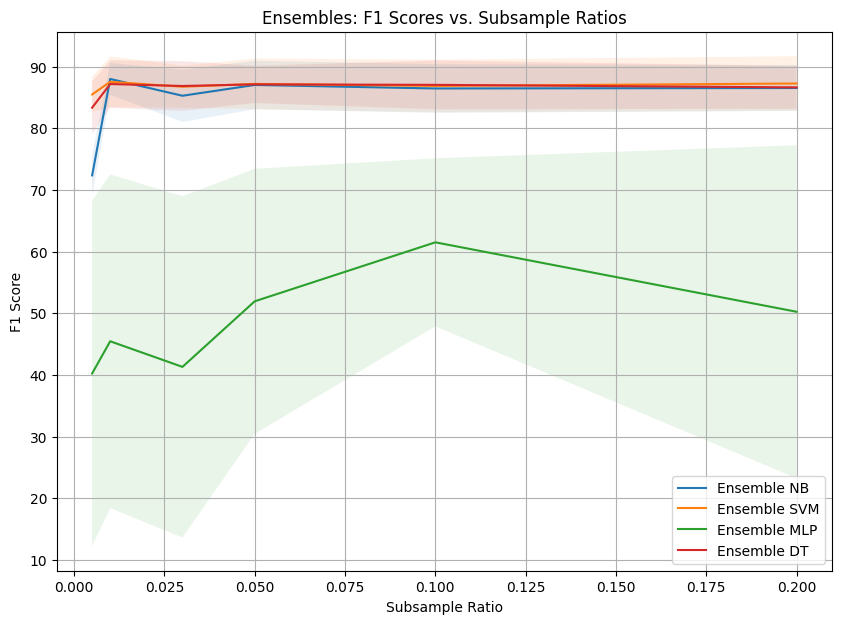

In [45]:
# organize results, labels, and standard deviation colors
ensemble_results = [nb_ens_results, svm_ens_results, mlp_ens_results, dt_ens_results]
ensemble_labels = ['Ensemble NB', 'Ensemble SVM', 'Ensemble MLP', 'Ensemble DT']

# plot the results
plt.figure(figsize=(10, 7))
for results, label in zip(ensemble_results, ensemble_labels):
    result_vals = [res[0] for res in results]
    std_vals = [res[1] for res in results]

    # plot average f1 values
    plt.plot(sample_ratios, result_vals, label=label)

    # add shading for standard deviation
    plt.fill_between(sample_ratios, 
                     [r - s for r, s in zip(result_vals, std_vals)], 
                     [r + s for r, s in zip(result_vals, std_vals)], 
                     alpha=0.1)

plt.xlabel('Subsample Ratio')
plt.ylabel('F1 Score')
plt.legend(loc='lower right')
plt.title("Ensembles: F1 Scores vs. Subsample Ratios")
plt.grid()
plt.show()

In [46]:
# set the same model hyperparameters for single models
nb_model = GaussianNB()
svm_model = svm.SVC(kernel="linear", probability=True)
dt_model = DecisionTreeClassifier(max_depth=5, max_features=5)
mlp_model = MLPClassifier(hidden_layer_sizes=(3,3), max_iter=30, tol=1e-1)

# evaluate a single naive bayes model with the same subsample ratios
nb_results = [k_fold_ensemble(x_train, y_train, 10, [nb_model], sample_ratio, True, False) for sample_ratio in sample_ratios]

10-fold CV using c.predict() and subsample ratio of 0.005
-------------------------------------------------------------------
Train Recall: 98.756 ±1.0596, Train F1 Score: 73.987 ±3.3715
Test Recall: 98.633 ±1.8619, Test F1 Score: 73.827 ±4.7750


10-fold CV using c.predict() and subsample ratio of 0.01
-------------------------------------------------------------------
Train Recall: 68.759 ±22.1192, Train F1 Score: 70.066 ±14.2953
Test Recall: 69.812 ±19.8668, Test F1 Score: 71.796 ±13.5530


10-fold CV using c.predict() and subsample ratio of 0.03
-------------------------------------------------------------------
Train Recall: 78.015 ±14.8938, Train F1 Score: 78.562 ±10.3015
Test Recall: 78.703 ±12.3839, Test F1 Score: 79.358 ±7.8851


10-fold CV using c.predict() and subsample ratio of 0.05
-------------------------------------------------------------------
Train Recall: 75.528 ±13.4193, Train F1 Score: 79.161 ±7.8383
Test Recall: 76.032 ±14.5975, Test F1 Score: 79.738 ±7.9297


10

In [47]:
# evaluate a single svm model with the same subsample ratios
svm_results = [k_fold_ensemble(x_train, y_train, 10, [svm_model], sample_ratio, True, False) for sample_ratio in sample_ratios]

10-fold CV using c.predict() and subsample ratio of 0.005
-------------------------------------------------------------------
Train Recall: 82.647 ±13.3552, Train F1 Score: 75.968 ±7.4077
Test Recall: 82.069 ±14.2110, Test F1 Score: 75.672 ±7.9485


10-fold CV using c.predict() and subsample ratio of 0.01
-------------------------------------------------------------------
Train Recall: 81.800 ±16.1437, Train F1 Score: 78.961 ±9.5599
Test Recall: 80.464 ±13.6624, Test F1 Score: 78.256 ±6.9264


10-fold CV using c.predict() and subsample ratio of 0.03
-------------------------------------------------------------------
Train Recall: 82.498 ±7.7256, Train F1 Score: 81.000 ±3.8406
Test Recall: 81.039 ±9.4351, Test F1 Score: 79.479 ±4.6196


10-fold CV using c.predict() and subsample ratio of 0.05
-------------------------------------------------------------------
Train Recall: 77.548 ±5.5079, Train F1 Score: 80.498 ±3.0868
Test Recall: 78.654 ±7.9663, Test F1 Score: 80.921 ±5.4464


10-fold

In [48]:
# evaluate a single mlp model with the same subsample ratios
mlp_results = [k_fold_ensemble(x_train, y_train, 10, [mlp_model], sample_ratio, True, False) for sample_ratio in sample_ratios]

10-fold CV using c.predict() and subsample ratio of 0.005
-------------------------------------------------------------------
Train Recall: 45.880 ±42.5251, Train F1 Score: 38.094 ±30.8159
Test Recall: 47.226 ±43.6333, Test F1 Score: 38.065 ±31.8469


10-fold CV using c.predict() and subsample ratio of 0.01
-------------------------------------------------------------------
Train Recall: 76.113 ±38.6822, Train F1 Score: 55.851 ±27.9900
Test Recall: 77.033 ±38.8413, Test F1 Score: 56.358 ±28.3385


10-fold CV using c.predict() and subsample ratio of 0.03
-------------------------------------------------------------------
Train Recall: 44.557 ±46.6953, Train F1 Score: 34.623 ±33.2030
Test Recall: 45.285 ±46.3368, Test F1 Score: 36.529 ±33.8232


10-fold CV using c.predict() and subsample ratio of 0.05
-------------------------------------------------------------------
Train Recall: 56.003 ±41.9108, Train F1 Score: 46.067 ±30.5642
Test Recall: 56.761 ±41.8846, Test F1 Score: 46.944 ±31.28

In [49]:
# evaluate a single decision tree model with the same subsample ratios 
dt_results = [k_fold_ensemble(x_train, y_train, 10, [dt_model], sample_ratio, True, False) for sample_ratio in sample_ratios]

10-fold CV using c.predict() and subsample ratio of 0.005
-------------------------------------------------------------------
Train Recall: 69.303 ±23.4356, Train F1 Score: 61.649 ±16.4235
Test Recall: 70.257 ±25.3551, Test F1 Score: 61.022 ±19.2189


10-fold CV using c.predict() and subsample ratio of 0.01
-------------------------------------------------------------------
Train Recall: 61.319 ±21.4015, Train F1 Score: 65.068 ±13.0246
Test Recall: 60.325 ±20.3473, Test F1 Score: 65.165 ±12.1264


10-fold CV using c.predict() and subsample ratio of 0.03
-------------------------------------------------------------------
Train Recall: 66.716 ±8.9123, Train F1 Score: 70.776 ±5.5643
Test Recall: 65.081 ±12.6113, Test F1 Score: 68.038 ±9.9409


10-fold CV using c.predict() and subsample ratio of 0.05
-------------------------------------------------------------------
Train Recall: 76.224 ±6.3066, Train F1 Score: 75.663 ±4.0568
Test Recall: 78.353 ±8.1144, Test F1 Score: 75.864 ±6.5122


10

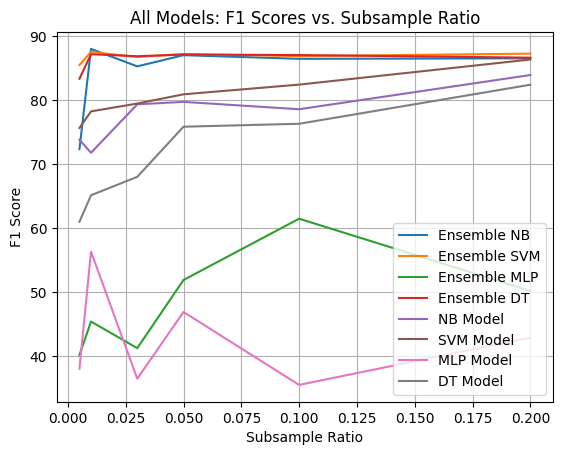

In [50]:
# make a list of results for all tests
results = [nb_ens_results, svm_ens_results, mlp_ens_results, dt_ens_results, nb_results, svm_results, mlp_results, dt_results]

# set the corresponding labels for all tests
labels = ['Ensemble NB', 'Ensemble SVM', 'Ensemble MLP', 'Ensemble DT', 'NB Model', 'SVM Model', 'MLP Model', 'DT Model']

# plot the results
for result, model in zip(results, labels):
    plt.plot(sample_ratios, [res[0] for res in result], label=model)

plt.xlabel('Subsample Ratio')
plt.ylabel('F1 Score')
plt.legend(loc='lower right')
plt.grid()
plt.title("All Models: F1 Scores vs. Subsample Ratio")
plt.show()

The cell below provides a better visualization with each classifier and the corresponding ensemble on a separate plot. 

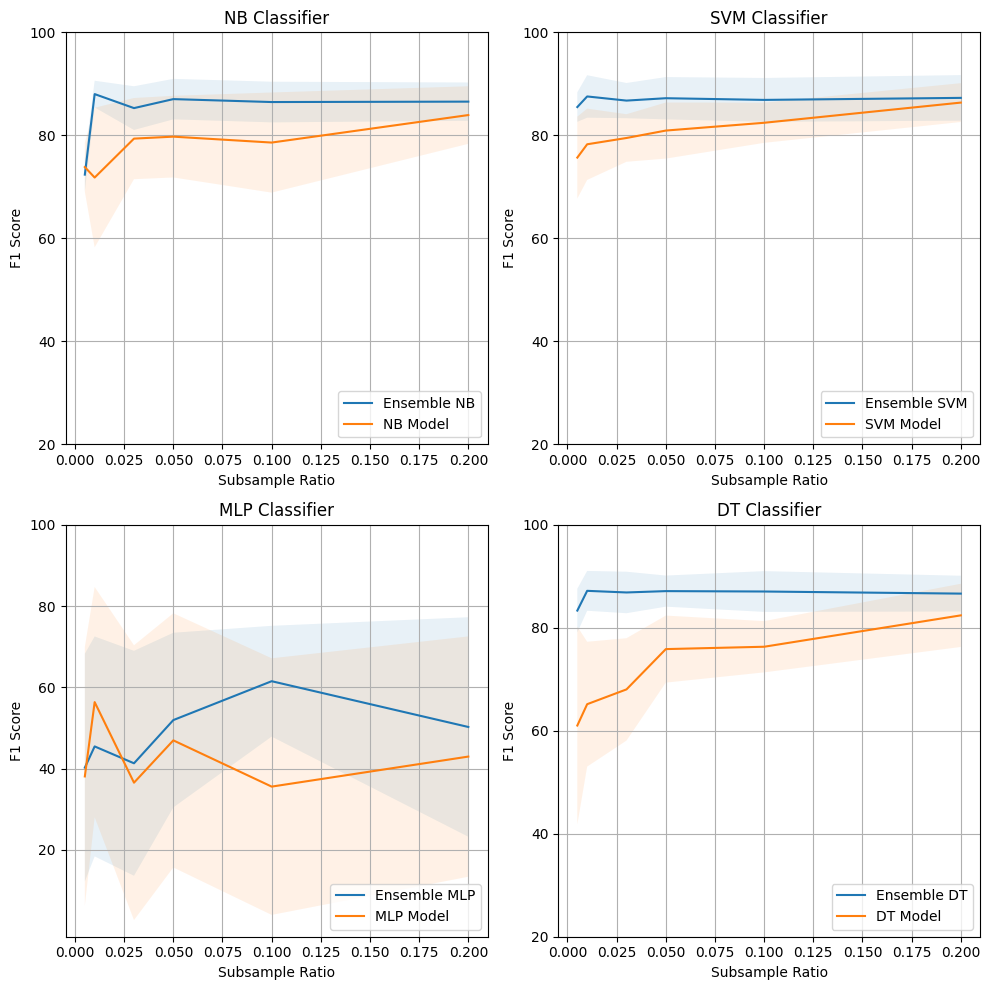

In [51]:
# create a grid of size 2 by 2
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# set the model names, ensemble results, and single model results
classifiers = ['NB', 'SVM', 'MLP', 'DT']
ens_results = [nb_ens_results, svm_ens_results, mlp_ens_results, dt_ens_results]
model_results = [nb_results, svm_results, mlp_results, dt_results]

for i, ax in enumerate(axes.flatten()):
    ax.set_title(f'{classifiers[i]} Classifier')
    
    # plot ensemble results with standard deviation
    result_vals = [res[0] for res in ens_results[i]]
    std_vals = [res[1] for res in ens_results[i]]
    ax.plot(sample_ratios, result_vals, label=f'Ensemble {classifiers[i]}')
    ax.fill_between(sample_ratios, 
                    [r - s for r, s in zip(result_vals, std_vals)], 
                    [r + s for r, s in zip(result_vals, std_vals)], 
                    alpha=0.1)
    
    # plot single model results with standard deviation
    result_vals = [res[0] for res in model_results[i]]
    std_vals = [res[1] for res in model_results[i]]
    ax.plot(sample_ratios, result_vals, label=f'{classifiers[i]} Model')
    ax.fill_between(sample_ratios, 
                    [r - s for r, s in zip(result_vals, std_vals)], 
                    [r + s for r, s in zip(result_vals, std_vals)], 
                    alpha=0.1)

    ax.set_xlabel('Subsample Ratio')
    ax.set_ylabel('F1 Score')
    ax.set_yticks([20, 40, 60, 80, 100])
    ax.legend(loc='lower right')
    ax.grid()

plt.tight_layout()
plt.show()

### Conclusions

- The results above showed that the ensemble models had higher performance and a lower or comparable standard deviation for all classifiers. 
- The ensemble models generally performed better than the single models when trained on lower subsample sizes because each of the 100 estimators was trained on a different subsample.
- The initial tests between the single models and the weak learners showed that the weak models reduced overfitting for the decision tree and multilayer perceptron. However, the reduction in overfitting for the multilayer perceptron introduced significantly more bias into the model. 
- Multilayer perceptrons are highly sensitive to random weight initialization. This sensitivity becomes more apparent when restricting the model to such a low number of iterations. Therefore, poorly initialized weights could cause the ensemble to have worse performance than a single, well-tuned model.
- The support vector machine, decision tree, and naive bayes ensembles had very similar evaluation scores.
- The custom ensembles (excluding the mlp ensemble) had slightly lower f1 scores than the initial random forest. However, the random forest with default parameters is overfitting, and the custom ensembles are not overfitting.
- The small increase in performance might not be worth the additional complexity of ensemble methods for all problems. However, the prediction of heart failure is a life-threatening problem where the additional complexity might be worth the performance increase. 

**References**
1. Kashou, A., Basit, H, & Malik, A. (2023). ST Segment. National Library of Medicine. https://www.ncbi.nlm.nih.gov/books/NBK459364/. Accessed October 2023.
2. Latha, C., & Jeeva, S. (2019). Improving the accuracy of prediction of heart disease risk based on ensemble classification techniques. Informatics in Medicine Unlocked. https://doi.org/10.1016/j.imu.2019.100203. Accessed October 2023.
3. Raschka, S. & Mirjalili, V. (2019). Python Machine Learning Ed. 3. Packt Publishing.